In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import skimage.measure

import random

In [6]:
train_x = np.zeros((1, 32, 32))
train_y = np.zeros((1, 32, 32))

map_list = ['master_big','willow','costacafe','map1','map2','map3']

for map_name in map_list:
  print(map_name)

  lines = 0
  with open('maps/'+map_name+'.csv') as f:
    lines = f.readlines()

  h = len(lines)
  w = len(lines[0].split(','))

  # Converts data to a list of integers
  map = []
  for line in lines:
    map.extend([int(c) for c in line.split(',')])

  map = np.reshape(map,[h,w])
  map = skimage.measure.block_reduce(map, (2,2), np.max)
  map = map/255
  h, w = map.shape

  diff_h = int((h-32*int(h/32))/2)
  r_h = int((h-32*int(h/32))%2) + diff_h
  diff_w = int((w-32*int(w/32))/2)
  r_w = int((w-32*int(w/32))%2) + diff_w
  map = map[r_h:-diff_h,r_w:-diff_w]

  # print(map.shape)
  h, w = map.shape

  # -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/humandensity-'+map_name+'5.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([int(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  data = skimage.measure.block_reduce(data, (2,2), np.max)
  data = data[r_h:-diff_h,r_w:-diff_w]
  data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))*255
  data = data/255

  # print(data.shape)
  hd, wd = data.shape

  inverted_map = np.add(map, np.full((h, w), -1))*255
  out = np.clip(np.add(data, inverted_map),0,255)

  # fig = plt.figure(figsize=(w/50,h/50))
  # plt.imshow(map, cmap='Greys_r', vmin=0, vmax=1)
  # plt.imshow(data, cmap='Reds_r', vmin=0, vmax=1, alpha=0.5)
  # plt.show()

  # -----------------------------------------------------------------------------------
  div = 32
  step = int(32/2)

  # fig = plt.figure(figsize=(w/step/2,h/step/2))

  num = 0
  start = train_x.shape[0] - 1
  for i in np.arange(w/step*h/step):
      # ax = fig.add_subplot(int(h/step), int(w/step), int(i+1))
      # ax.set_aspect('equal')
      # ax.axis('off')
      c = int(i%(w/step))
      r = int(i/(w/step))
      submap = map[step*r:step*r+div, step*c:step*c+div]
      subdata = data[step*r:step*r+div, step*c:step*c+div]
      if np.mean(submap) > 0.5 and np.mean(submap) < 1 and np.mean(subdata) < 0.95 and submap.shape == (32, 32):
          num = num + 1
          submap = skimage.measure.block_reduce(submap, (int(div/32),int(div/32)), np.max)
          # ax.imshow(submap, cmap='Greys_r', vmin=0, vmax=1)
          subdata = skimage.measure.block_reduce(subdata, (int(div/32),int(div/32)), np.max)
          # ax.imshow(subdata, cmap='Reds_r', vmin=0, vmax=1, alpha=0.5)
          train_x = np.append(train_x, np.expand_dims(submap, axis=0), axis=0)
          train_y = np.append(train_y, np.expand_dims(subdata, axis=0), axis=0)

  for j in np.arange(3):
      for i in np.arange(num)+start:
          train_x = np.append(train_x, np.expand_dims(np.rot90(train_x[i,:,:], k=j+1, axes=(0, 1)),axis=0), axis=0)
          train_y = np.append(train_y, np.expand_dims(np.rot90(train_y[i,:,:], k=j+1, axes=(0, 1)),axis=0), axis=0)

  # fig.subplots_adjust(wspace=0.5, hspace=0.5)
  # plt.show()

train_x = np.delete(train_x, 0, 0)
train_y = np.delete(train_y, 0, 0)

master_big
willow
costacafe
map1
map2
map3


In [252]:
num_validation = 10  #int(num * 0.1)

original_data_x = train_x
original_data_y = train_y

In [253]:
train_x = original_data_x
train_y = original_data_y

p = np.random.permutation(len(train_x))
train_x = train_x[p]
train_y = train_y[p]

num = train_x.shape[0]
num_test = int(num * 0.2)
num_train = num - num_test - num_validation

validation_x = train_x[:num_validation,:,:]
validation_y = train_y[:num_validation,:,:]

train_x = train_x[num_validation:,:,:]
train_y = train_y[num_validation:,:,:]

test_x = train_x[:num_test,:,:]
test_y = train_y[:num_test,:,:]

train_x = train_x[num_test:,:,:]
train_y = train_y[num_test:,:,:]

print(train_x.shape)
print(test_x.shape)
print(validation_x.shape)

(2544, 32, 32)
(638, 32, 32)
(10, 32, 32)


2239


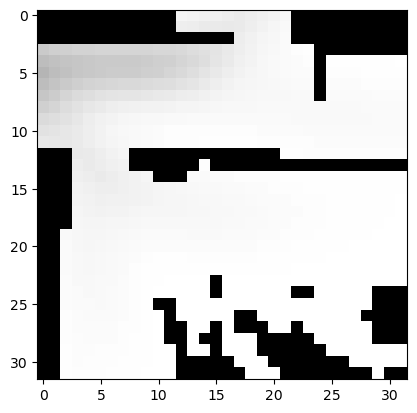

In [254]:
div = 32

i = int(random.random()*train_x.shape[0])
print(i)
c = int(i%(w/step))
r = int(i/(w/step))
submap = train_x[i,:,:]
subdata = train_y[i,:,:]
plt.imshow(np.multiply(submap,subdata), cmap='Greys_r', vmin=0, vmax=1)
# plt.imshow(submap, cmap='Greys_r', vmin=0, vmax=1)
# plt.imshow(subdata, cmap='Reds_r', vmin=0, vmax=1, alpha=0.5)
plt.show()

In [255]:
# (train_x, _), (test_x, _) = tf.keras.datasets.cifar10.load_data()
# train_x = train_x/255
# test_x = test_x/255

# train_x = train_x[:,:,:,0]*0.2989 + train_x[:,:,:,1]*0.5870 + train_x[:,:,:,2]*0.1140
# test_x = test_x[:,:,:,0]*0.2989 + test_x[:,:,:,1]*0.5870 + test_x[:,:,:,2]*0.1140
# # train_x = np.stack((train_x,train_x,train_x), axis=3)
# # test_x = np.stack((test_x,test_x,test_x), axis=3)

# validation_x = train_x[:num_validation,:,:]
# train_x = train_x[num_validation:,:,:]

# train_y = train_x
# test_y = test_x
# validation_y = validation_x

# print(train_x.shape)
# print(test_x.shape)
# print(validation_x.shape)

In [263]:
# CNN-11  |  CNN-21  |  CNN-31
fil_array = [4,8,8]                         #Num filters first conv: 4, 8 or 8
lay_array = [1,3,5]                         #Layers per dense block: 1, 3 or 5
learn_array = [8.71e-5,3.72e-4,1.51e-4]     #Learning rates
decaylearn_array = [0.9984,0.9984,0.9985]   #Learning rate decays
wdecay_array = [1.11e-6,5.53e-7,4.58e-5]    #Weight decays
dropout_array = [0.307,0.120,0.349]         #Dropout probability

arc = 2                                     #[0,1,2]

filters = fil_array[arc]        
layers_in_dense = lay_array[arc]

def dense_factor(inputs):
    h_1 = layers.BatchNormalization()(inputs)
    output = layers.Conv2D(32, (3,3), padding='same', activation='relu')(h_1)
    return output

def dense_block(inputs, upsampling):
    concatenated_inputs = inputs
    concatenated_inputs_less = []
    for i in range(layers_in_dense):
        x = dense_factor(concatenated_inputs)
        concatenated_inputs = layers.concatenate([concatenated_inputs, x], axis=3)
        concatenated_inputs_less = layers.concatenate([concatenated_inputs, x], axis=3)
        if(i == layers_in_dense - 1 and upsampling):
            concatenated_inputs = concatenated_inputs_less

    return concatenated_inputs

input_img = layers.Input(shape=(32, 32, 1))
tf.random.set_seed(0)
lays = layers.Dropout(dropout_array[arc]/10)(input_img)
lays = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(lays)
filters = filters+2
lays = dense_block(lays,False)
layerX = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(lays)
filters = filters+1
lays = layers.MaxPooling2D((2, 2), strides=2)(layerX)
lays = dense_block(lays,False)
layerY = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(lays)
lays = layers.MaxPooling2D((2, 2), strides=2)(layerY)

lays = dense_block(lays,True)

lays = layers.Conv2DTranspose(filters, (3, 3), strides=2, padding='same')(lays)
lays = layers.Add()([layerY,lays])
lays = dense_block(lays,True)
filters = filters-1
lays = layers.Conv2DTranspose(filters, (3, 3), strides=2, padding='same')(lays)
lays = layers.Add()([layerX,lays])
lays = dense_block(lays,False)
filters = filters-2
lays = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(lays)
lays = layers.Dense(units=2, activation='softmax')(lays)

model = models.Model(input_img, lays)

# model.summary()

In [264]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=learn_array[arc],
                    decay_steps=10,
                    decay_rate=decaylearn_array[arc])

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule,weight_decay=wdecay_array[arc])
lr_metric = get_lr_metric(opt)

model.compile(
    optimizer=opt,
    # Loss function to minimize
    loss='binary_crossentropy',
    # List of metrics to monitor
    metrics=['mean_squared_error'],
) 

In [265]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15),
    # tf.keras.callbacks.ModelCheckpoint(filepath='IRI_models/model.{epoch:02d}-{val_loss:.2f}.h5'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = model.fit(
    x=train_x,
    y=np.stack((1-train_y,train_y),axis=3),
    batch_size=50,
    epochs=100, #100
    validation_data=(test_x, np.stack((1-test_y,test_y),axis=3)),
    callbacks=my_callbacks,
)

Epoch 1/100
51/51 [==============================] - 58s 834ms/step - loss: 0.4822 - mean_squared_error: 0.0583 - val_loss: 0.5574 - val_mean_squared_error: 0.0529
Epoch 2/100
51/51 [==============================] - 17s 333ms/step - loss: 0.4120 - mean_squared_error: 0.0451 - val_loss: 0.4554 - val_mean_squared_error: 0.0473
Epoch 3/100
51/51 [==============================] - 13s 254ms/step - loss: 0.4071 - mean_squared_error: 0.0437 - val_loss: 0.4367 - val_mean_squared_error: 0.0632
Epoch 4/100
51/51 [==============================] - 13s 248ms/step - loss: 0.4028 - mean_squared_error: 0.0421 - val_loss: 0.4300 - val_mean_squared_error: 0.0645
Epoch 5/100
51/51 [==============================] - 14s 277ms/step - loss: 0.4013 - mean_squared_error: 0.0411 - val_loss: 0.4393 - val_mean_squared_error: 0.0589
Epoch 6/100
51/51 [==============================] - 13s 252ms/step - loss: 0.3975 - mean_squared_error: 0.0399 - val_loss: 0.4172 - val_mean_squared_error: 0.0433
Epoch 7/100
51/5

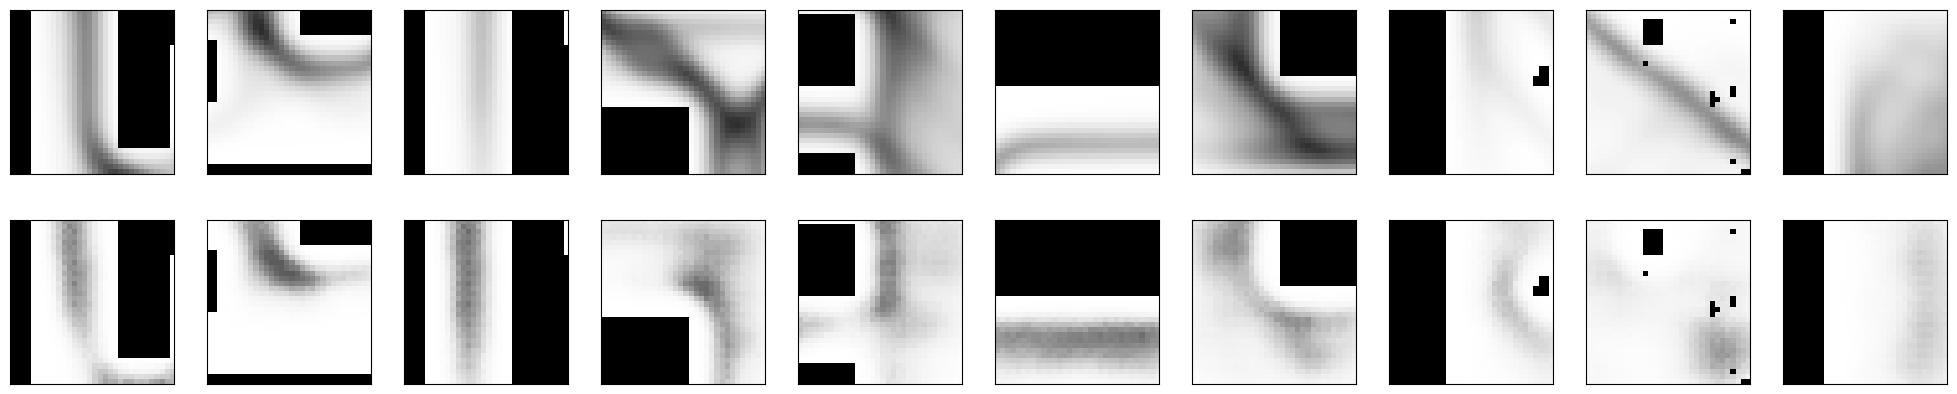

In [266]:
aux_x = validation_x
aux_y = validation_y

output = model.predict(aux_x,verbose=0)[:,:,:,1]

n = num_validation  # How many images we will display
plt.figure(figsize=(25, 5))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    ax.imshow(np.multiply(aux_x[i],aux_y[i]), cmap='Greys_r', vmin=0, vmax=1)
    # ax.imshow(aux_x[i], cmap='Greys_r', vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.imshow(np.multiply(aux_x[i],output[i]), cmap='Greys_r', vmin=0, vmax=1)
    # ax.imshow(output[i], cmap='Greys_r', vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# Display original
plt.show()

1/1 - 3s - loss: 0.3783 - mean_squared_error: 0.0315 - 3s/epoch - 3s/step


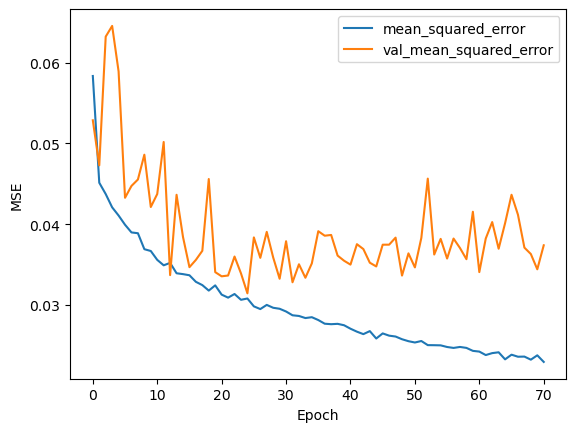

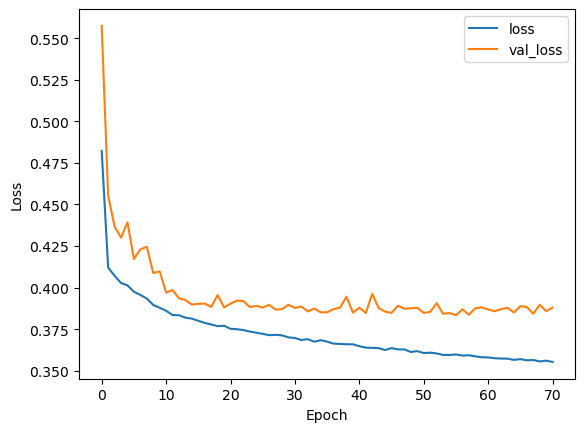

In [267]:
test_loss, test_acc = model.evaluate(aux_x,  np.stack((1-aux_y,aux_y),axis=3), verbose=2)

plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label = 'val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')

plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

map2


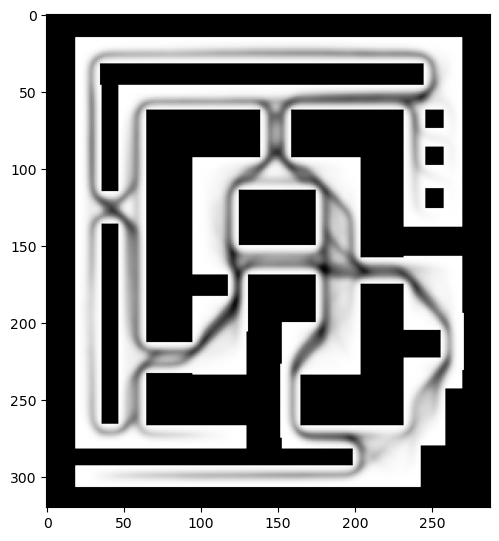

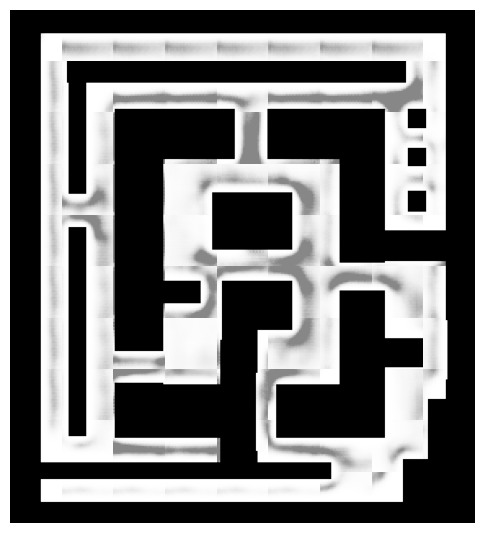

In [8]:
map_list = ['map2'] #'master_big','willow','costacafe','map1','map2','map3'

for map_name in map_list:
  print(map_name)

  lines = 0
  with open('maps/'+map_name+'.csv') as f:
    lines = f.readlines()

  h = len(lines)
  w = len(lines[0].split(','))

  # Converts data to a list of integers
  map = []
  for line in lines:
    map.extend([int(c) for c in line.split(',')])

  map = np.reshape(map,[h,w])
  map = skimage.measure.block_reduce(map, (2,2), np.max)
  map = map/255
  h, w = map.shape

  diff_h = int((h-32*int(h/32))/2)
  r_h = int((h-32*int(h/32))%2) + diff_h
  diff_w = int((w-32*int(w/32))/2)
  r_w = int((w-32*int(w/32))%2) + diff_w
  map = map[r_h:-diff_h,r_w:-diff_w]

  # print(map.shape)
  h, w = map.shape

# -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/humandensity-'+map_name+'5.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([int(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  data = skimage.measure.block_reduce(data, (2,2), np.max)
  data = data[r_h:-diff_h,r_w:-diff_w]
  data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))*255
  data = data/255

  # print(data.shape)
  hd, wd = data.shape

  inverted_map = np.add(map, np.full((h, w), -1))*255
  out = np.clip(np.add(data, inverted_map),0,255)

  fig = plt.figure(figsize=(w/50,h/50))
  # plt.imshow(map, cmap='Greys_r', vmin=0, vmax=1)
  # plt.imshow(data, cmap='Reds_r', vmin=0, vmax=1, alpha=0.5)
  plt.imshow(np.multiply(map,data), cmap='Greys_r', vmin=0, vmax=1)
  plt.show()

  # -----------------------------------------------------------------------------------
  div = 32

  fig = plt.figure(figsize=(w/div*2/3,h/div*2/3))

  num = 0
  start = train_x.shape[0] - 1
  for i in np.arange(w/div*h/div):
      ax = fig.add_subplot(int(h/div), int(w/div), int(i+1))
      ax.set_aspect('equal')
      ax.axis('off')
      c = int(i%(w/div))
      r = int(i/(w/div))
      submap = map[div*r:div*r+div, div*c:div*c+div]
      subdata = model.predict(np.expand_dims(np.expand_dims(submap,axis=0),axis=3),verbose=0)[:,:,:,1]
      submap = skimage.measure.block_reduce(submap, (int(div/32),int(div/32)), np.max)
      # ax.imshow(submap, cmap='Greys_r', vmin=0, vmax=1)
      # ax.imshow(subdata[0,:,:], cmap='Reds_r', vmin=0, vmax=1, alpha=0.5)
      ax.imshow(np.multiply(submap,subdata[0,:,:]), cmap='Greys_r', vmin=0, vmax=1)

  # fig.subplots_adjust(wspace=0.5, hspace=0.5)
  fig.subplots_adjust(wspace=0, hspace=0)

  plt.show()

In [4]:
# model.save('IRI_models/20june_16px_steps')
# model = tf.keras.models.load_model('IRI_models/16june_8px_steps')